# **5505 - Assignment 6: Image Classification**



### `Name: Shiva Chakravarthy`

Dataset: https://www.kaggle.com/puneet6060/intel-image-classification/code

Goal: Build a CNN based image classifier, train and test the model using the following dataset.

### **Step 1: Import Libraries**


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from pathlib import Path
import cv2
from pathlib import Path
from PIL import Image
from random import randint
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from zipfile import ZipFile
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential, load_model, Model
import matplotlib.gridspec as gridspec
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import tensorflow as tf
from tensorflow.keras import optimizers

import os
import glob as gb

In [ ]:
!unzip /content/seg_pred.zip
!unzip /content/seg_test.zip
!unzip /content/seg_train.zip

In [11]:
test_dir = '/content/seg_test/seg_test'
train_dir = '/content/seg_train/seg_train'
pred_dir = '/content/seg_pred/seg_pred'

### **Step 2: Visualising the test and train dataset images**


In [9]:
# Distribution of Testing Data
print('Testing Data Directory:')
for folder in os.listdir(test_dir):
    files=gb.glob(pathname=str(test_dir + '/' + folder +'/*.jpg'))
    print(f'{len(files):4} images are founnd in {folder} folder.')

print('-'*70)

# Distribution of Training Data
print('Training Data Directory:')
for folder in os.listdir(train_dir):
    files=gb.glob(pathname=str(train_dir + '/' + folder +'/*.jpg'))
    print(f'{len(files):4} images are founnd in {folder} folder.')

print('-'*70)

# Distribution of Prediction Data
print('Prediction Data Directory:')
files= gb.glob(pathname=str(pred_dir + "/*.jpg"))
print(f"{len(files)} images are found in predict data.")

Testing Data Directory:
 501 images are founnd in street folder.
 525 images are founnd in mountain folder.
 510 images are founnd in sea folder.
 553 images are founnd in glacier folder.
 474 images are founnd in forest folder.
 437 images are founnd in buildings folder.
----------------------------------------------------------------------
Training Data Directory:
2382 images are founnd in street folder.
2512 images are founnd in mountain folder.
2274 images are founnd in sea folder.
2404 images are founnd in glacier folder.
2271 images are founnd in forest folder.
2191 images are founnd in buildings folder.
----------------------------------------------------------------------
Prediction Data Directory:
7301 images are found in predict data.


In [10]:
image_directories = ['buildings','forest','glacier','mountain','sea','street']
class_dict ={'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}


#Reading of train dataset
train_images=[]
train_classes =[]
if len(image_directories)!=0:
  for img_dir in image_directories:
    for path in Path('/content/seg_train/seg_train'+'/'+img_dir).iterdir():
      if path.name.endswith('.jpg'):
        img = cv2.imread(str(path))
        img = cv2.resize(img,(150,150))  #Resize the image, Some images are different sizes.
        train_images.append(img)
        train_classes.append(img_dir)
elif len(image_directories) == 0: 
  for path in Path('/content/seg_train/seg_train').iterdir():
    if path.name.endswith('.jpg'):
      img = cv2.imread(str(path))
      img = cv2.resize(img,(150,150))  #Resize the image, Some images are different sizes.
      train_images.append(img)

#Reading of test dataset
test_images=[]
test_classes =[]
if len(image_directories)!=0:
  for img_dir in image_directories:
    for path in Path('/content/seg_test/seg_test'+'/'+img_dir).iterdir():
      if path.name.endswith('.jpg'):
        img = cv2.imread(str(path))
        img = cv2.resize(img,(150,150))  #Resize the image, Some images are different sizes.
        test_images.append(img)
        test_classes.append(img_dir)
elif len(image_directories) == 0: 
  for path in Path('/content/seg_test/seg_test').iterdir():
    if path.name.endswith('.jpg'):
      img = cv2.imread(str(path))
      img = cv2.resize(img,(150,150))  #Resize the image, Some images are different sizes.
      test_images.append(img)

In [11]:
#For train dataset
train_labels = [class_dict[item] for item in train_classes]
train_labels = np.array(train_labels)

#for test dataset
test_labels = [class_dict[item] for item in test_classes]
test_labels = np.array(test_labels)

In [12]:
# convert list of images to numpy array
train_images = np.array(train_images)
train_classes = np.array(train_classes)
test_images = np.array(test_images)
test_classes = np.array(test_classes)

In [13]:
print('Shape of train dataset Images:', train_images.shape)
print('Shape of train dataset Classes:', train_classes.shape)
print('Shape of test dataset Images:', test_images.shape)
print('Shape of test dataset Classes:', test_classes.shape)

Shape of train dataset Images: (14034, 150, 150, 3)
Shape of train dataset Classes: (14034,)
Shape of test dataset Images: (3000, 150, 150, 3)
Shape of test dataset Classes: (3000,)


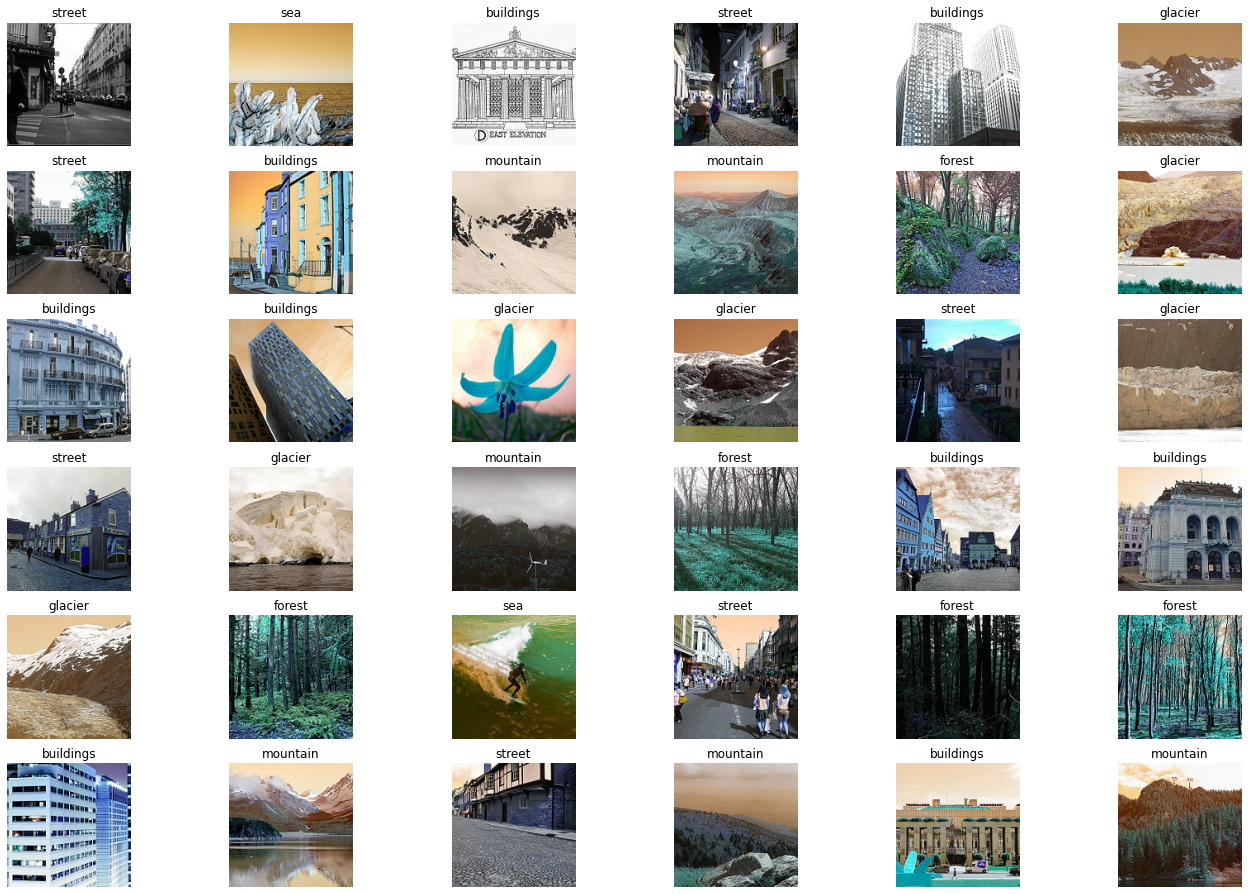

In [14]:
#Displaying train dataset images
plt.subplots_adjust(0,0,3,3)
for i in range(0,6*6):
  random_number = randint(0, len(train_images))
  img = train_images[random_number]
  plt.subplot(6,6,i+1)
  plt.title(train_classes[random_number])
  plt.axis('off')
  plt.imshow(img)

plt.show();

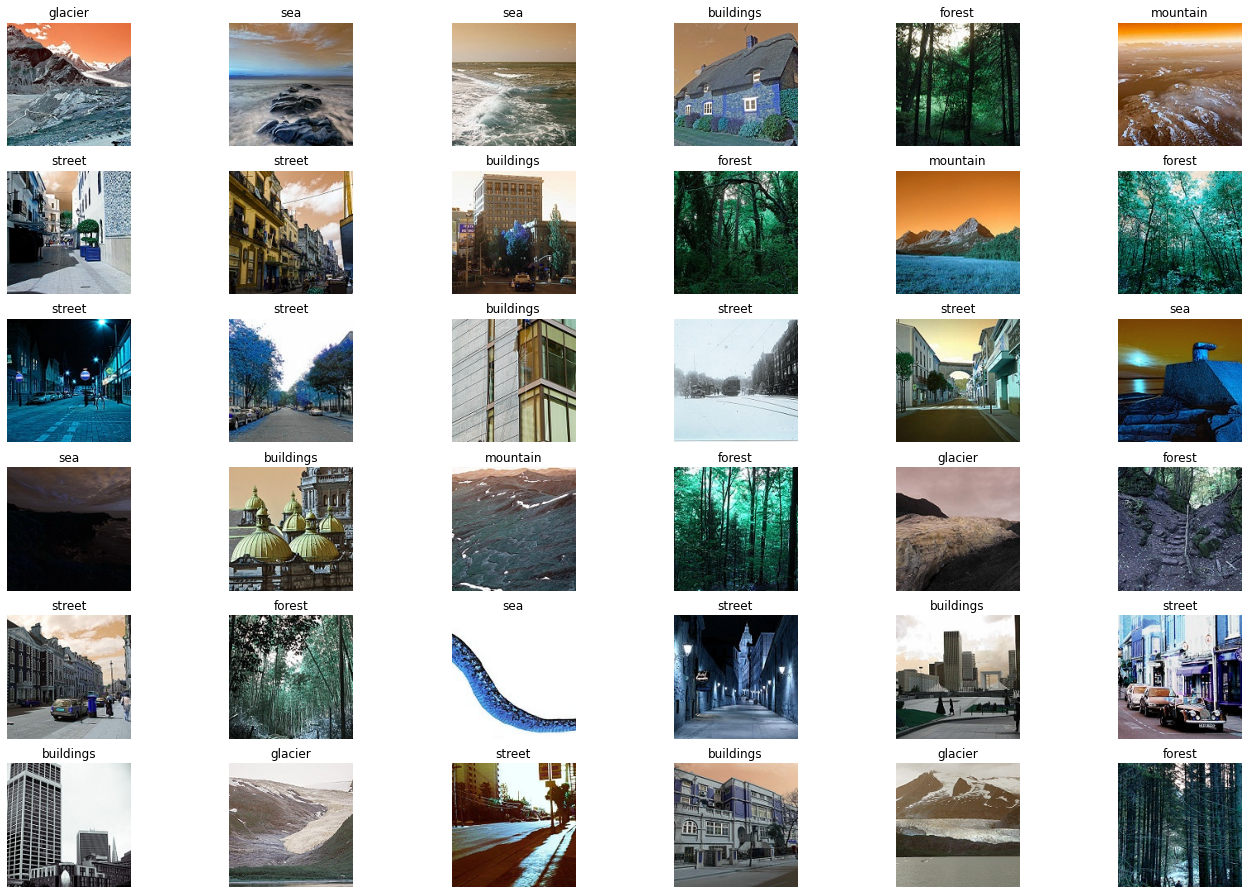

In [15]:
#Displaying test dataset images
plt.subplots_adjust(0,0,3,3)
for i in range(0,6*6):
  random_number = randint(0, len(test_images))
  img = test_images[random_number]
  plt.subplot(6,6,i+1)
  plt.title(test_classes[random_number])
  plt.axis('off')
  plt.imshow(img)

plt.show();

### **Step 3: Develop CNN Model**


In [16]:
# My label encoder
def my_label_encoder(classes):
  class_dict ={'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}
  labels = [class_dict[item] for item in classes]
  return labels

def my_label_decoder(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain', 6:'unknown'}
    return labels[class_code]


In [17]:
train_labels = my_label_encoder(train_classes)
train_labels = np.array(train_labels)

In [19]:
# Developing CNN model for Image classification
model=Models.Sequential()

model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Flatten())
model.add(Layers.Dense(180,activation='relu'))
model.add(Layers.Dense(100,activation='relu'))
model.add(Layers.Dense(50,activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(6,activation='softmax'))

model.compile(optimizer=Optimizer.Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [20]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 200)     5600      
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 180)     324180    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 180)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 180)       291780    
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 140)       226940    
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 23, 100)       126100    
                                                        

### **Step 4: Validate CNN Model with 10-Fold cross validation**

In [23]:
#set early stopping criteria
pat = 2 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)


#Function for cross validation

model_history = []
for i in range (0,10):
  print("Training on Fold: ",i+1)
  model_history.append(model.fit(train_images, train_labels, epochs=20, callbacks=[early_stopping],
              verbose=1, validation_split=0.1))
  print("======="*12, end="\n\n\n")
  print(model_history)



Training on Fold:  1
Epoch 1/20
395/395 [==============================] - 204s 515ms/step - loss: 1.0056 - accuracy: 0.6220 - val_loss: 1.3063 - val_accuracy: 0.3568
Epoch 2/20
395/395 [==============================] - 204s 516ms/step - loss: 0.8487 - accuracy: 0.7008 - val_loss: 1.1808 - val_accuracy: 0.5285
Epoch 3/20
395/395 [==============================] - 204s 516ms/step - loss: 0.7664 - accuracy: 0.7367 - val_loss: 0.7171 - val_accuracy: 0.6738
Epoch 4/20
395/395 [==============================] - 204s 516ms/step - loss: 0.6903 - accuracy: 0.7697 - val_loss: 1.3389 - val_accuracy: 0.4979
Epoch 5/20
395/395 [==============================] - 203s 515ms/step - loss: 0.6368 - accuracy: 0.7894 - val_loss: 1.0047 - val_accuracy: 0.5819
Epoch 00005: early stopping


Training on Fold:  2
Epoch 1/20
395/395 [==============================] - 204s 516ms/step - loss: 0.5864 - accuracy: 0.8057 - val_loss: 0.9748 - val_accuracy: 0.6261
Epoch 2/20
395/395 [==============================] 

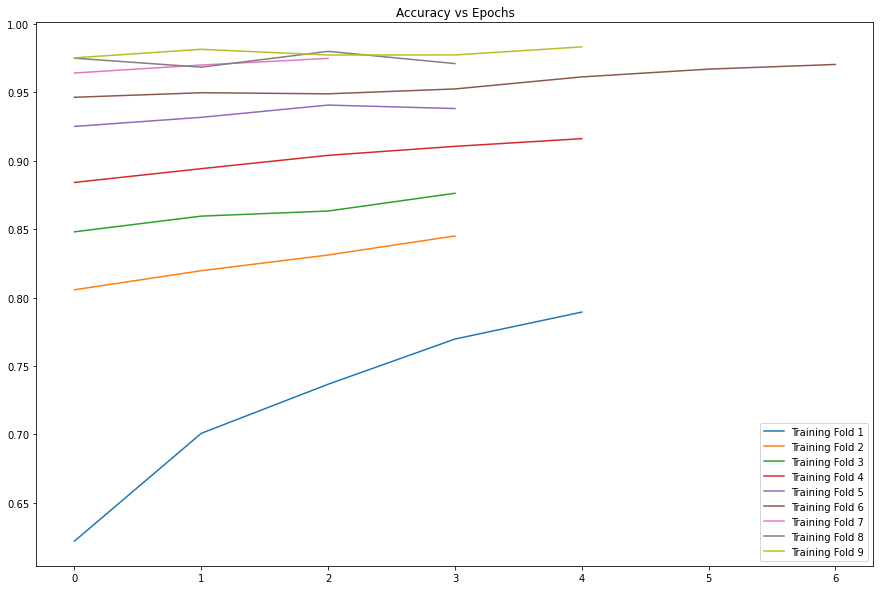

In [24]:
plt.figure(figsize=(15,10))
plt.title('Accuracy vs Epochs')
# plot_labels = 'Training Fold ' + i+1
for i in range(0,9):
  plt.plot(model_history[i].history['accuracy'], label='Training Fold '+str(i+1))

plt.legend() 
plt.show()

In [25]:
# Validation with test data
# convert test  images to numpy array
test_images = np.array(test_images)
test_classes = np.array(test_classes)


In [26]:
# We will check shape of images and labels
print('Shape of Images:', test_images.shape)
print('Shape of Classes:', test_classes.shape)

Shape of Images: (3000, 150, 150, 3)
Shape of Classes: (3000,)


In [27]:
# Label encoding for test classes
test_labels = my_label_encoder(test_classes)
test_labels = np.array(test_labels)

In [28]:
model.evaluate(test_images, test_labels)
model.

94/94 [==============================] - 18s 188ms/step - loss: 0.9247 - accuracy: 0.8353


[0.924651026725769, 0.8353333473205566]

### **Step 5:  Predciting the labels for new images**

In [47]:
from keras.models import Sequential, load_model, Model

In [ ]:
Model.p

In [41]:
#Reading of pred dataset
pred_images=[]
pred_classes =[]

for path in Path('/content/seg_pred/seg_pred').iterdir():
    if path.name.endswith('.jpg'):
      img = cv2.imread(str(path))
      img = cv2.resize(img,(150,150))  #Resize the image, Some images are different sizes.
      pred_images.append(img)


In [42]:
pred_images = np.array(pred_images)
pred_images.shape

(7301, 150, 150, 3)

In [43]:
def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]


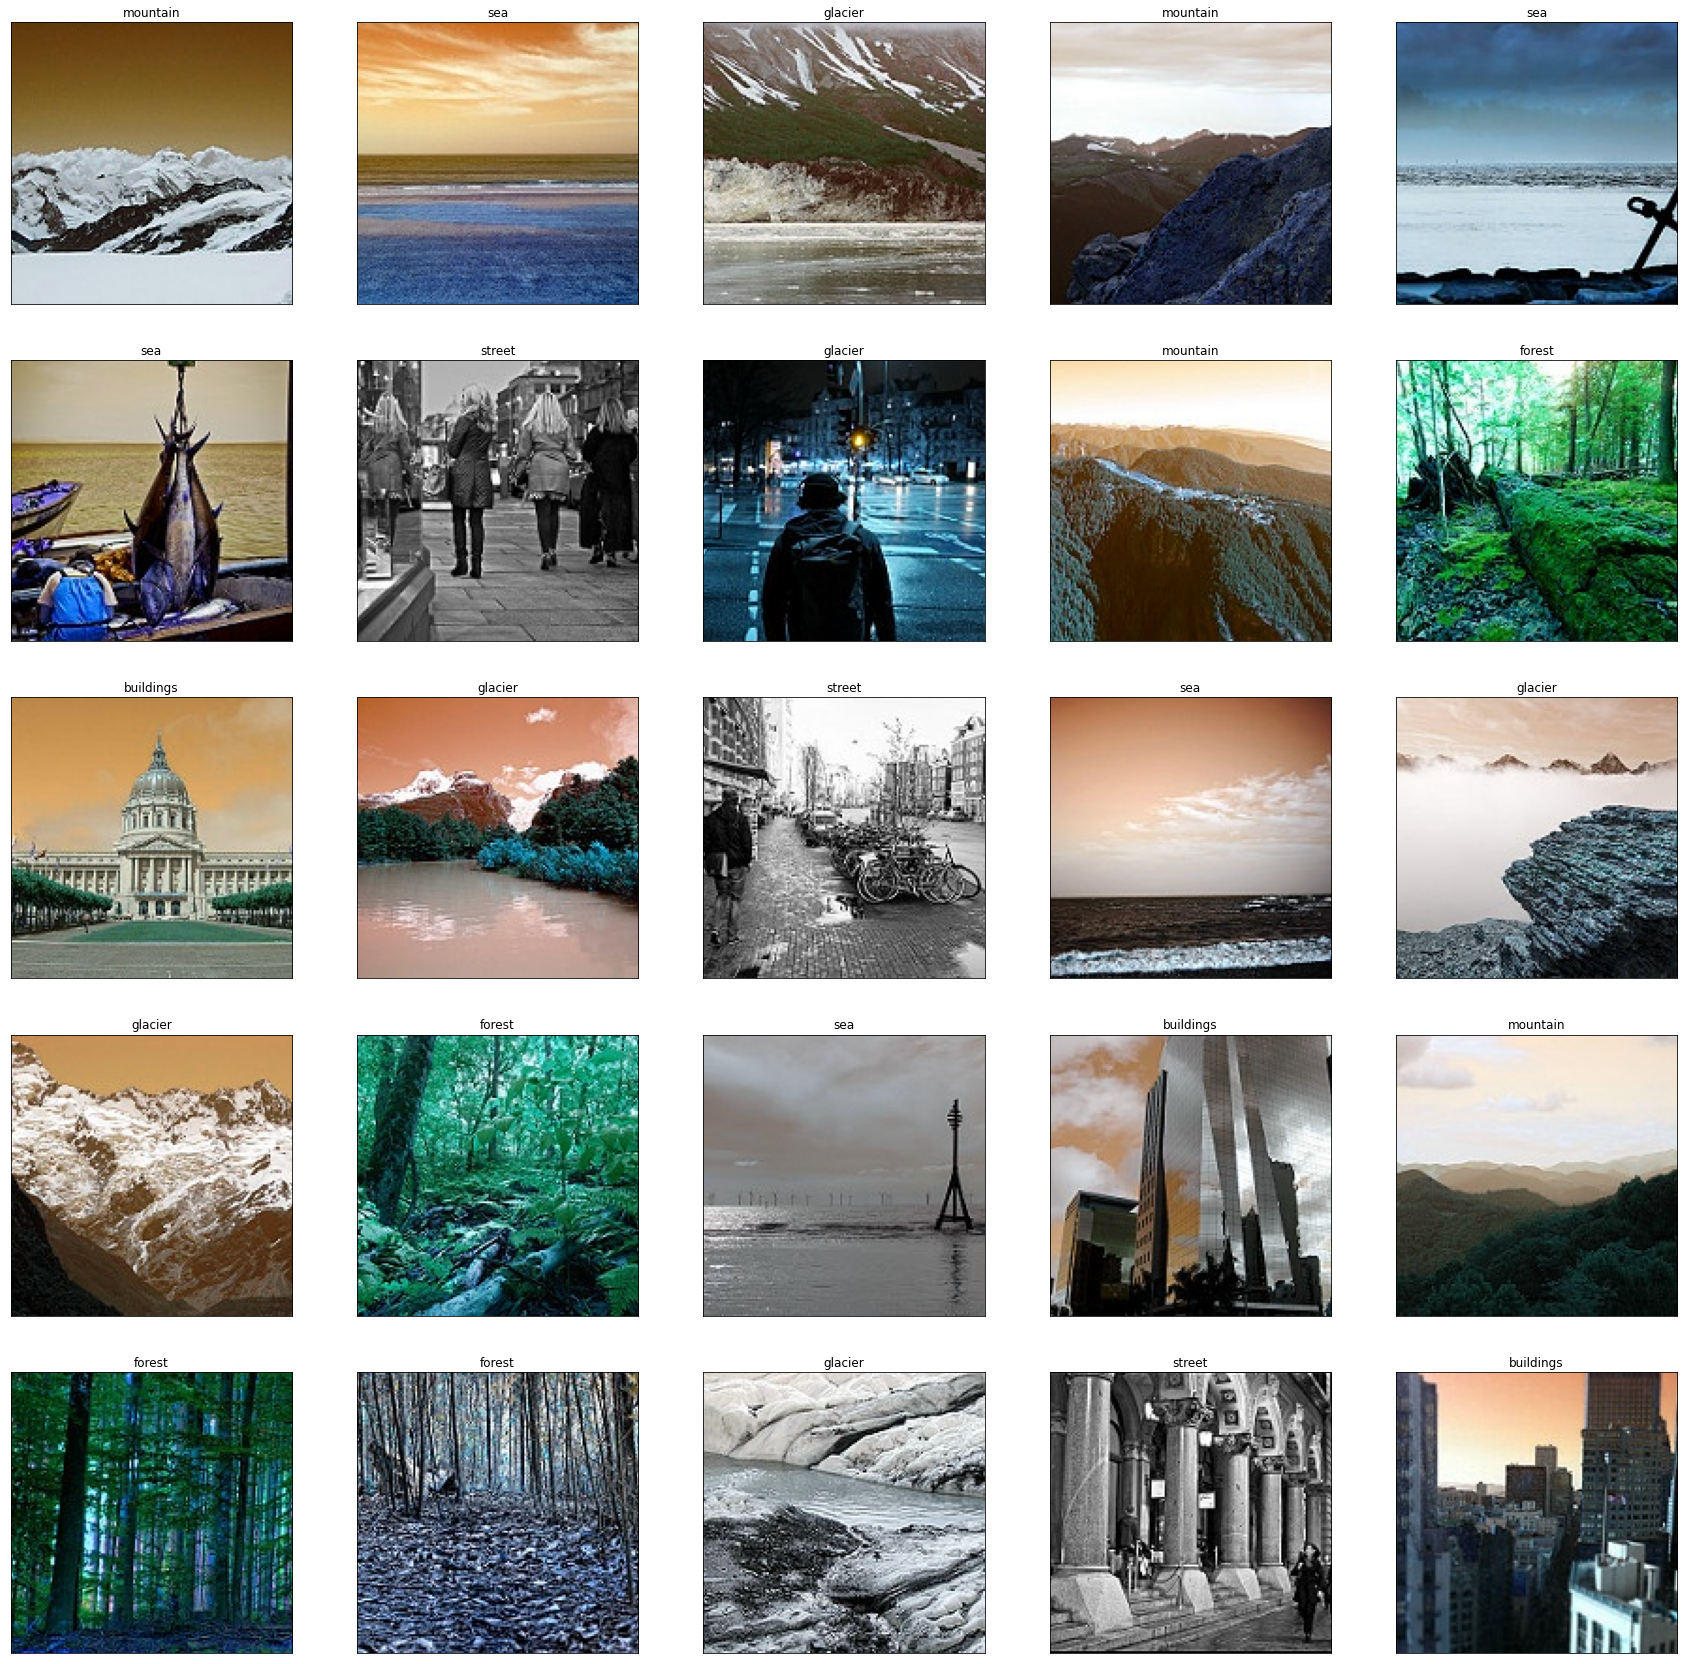

In [77]:
fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(1, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_class = get_classlabel(np.argmax(model.predict(pred_image), axis=-1)[0])
    # print(pred_class)
    pred_prob = model.predict(pred_image).reshape(6)
    # print(pred_prob)
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)

fig.show()


### **Step 6:  Confusion matrix of CNN model**


In [78]:
predictions = model.predict(test_images) 

In [79]:
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

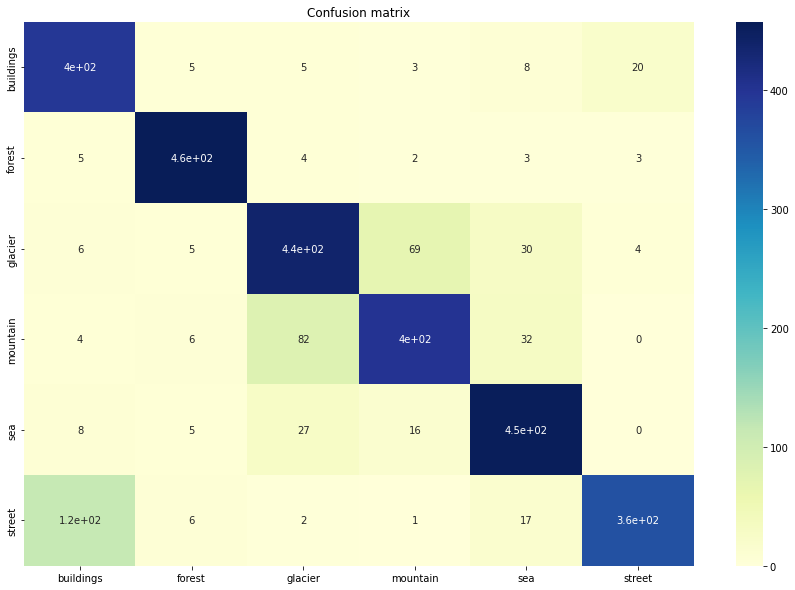

In [80]:
import sklearn.metrics as metrics
import seaborn as sn
CM = confusion_matrix(test_labels, pred_labels)
fig, ax = plt.subplots(figsize =(15,10))
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           cmap="YlGnBu",
           annot_kws={"size": 10}, 
           xticklabels=image_directories, 
           yticklabels=image_directories, ax = ax)
ax.set_title('Confusion matrix')
plt.show()


### **Step 7:  Transfer Learning model using AlexNet**

In [24]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms  
import torchvision
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import pandas as pd
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor,Normalize, RandomHorizontalFlip, Resize
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

In [25]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)


AlexNet_model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
from torch import nn

AlexNet_model.classifier[4] = nn.Linear(4096,1024)

# 3rd And Last Classifiers are Updated: i.e., the output layer of the network. 
AlexNet_model.classifier[6] = nn.Linear(1024,10)


In [27]:
AlexNet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
AlexNet_model.to(device)

cuda:0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [29]:
import torch.optim as optim
import torch.nn as nn

#Loss Calculation
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD) Recording
optimizer = optim.SGD(AlexNet_model.parameters(), lr=0.001, momentum=0.9)

In [30]:
transform = torchvision.transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(p=0.5), # It is flipped and Rotated Randomly
    transforms.ColorJitter(0.3,0.4,0.4,0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
    ])


transform_tests = torchvision.transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.255, 0.245, 0.235))
    ])

In [31]:
train_data = torchvision.datasets.ImageFolder(root=train_dir,transform=transform)
test_data = torchvision.datasets.ImageFolder(root=test_dir,transform=transform_tests)


valid_size = 0.15

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
classes=('buildings','forest','glacier','mountain','sea','street')

In [32]:
train_loader = DataLoader(train_data,batch_size=50,sampler=train_sampler,num_workers=2)
valid_loader = DataLoader(train_data, batch_size =100, sampler=valid_sampler, num_workers=3)
test_loader= DataLoader(test_data,batch_size=32,shuffle=False,num_workers=2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [33]:
train_on_gpu = torch.cuda.is_available()

device =  torch.device('cuda' if torch.cuda.is_available else 'cpu')



In [38]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy about the 3000 test images with regard to the network: %d %%' % (
    100 * correct / total))

Accuracy about the 3000 test images with regard to the network: 90 %


In [39]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(6):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of buildings : 85 %
Accuracy of forest : 98 %
Accuracy of glacier : 86 %
Accuracy of mountain : 85 %
Accuracy of   sea : 100 %
Accuracy of street : 83 %
